# Tow-Based Discontinuous Composite (TBDC) property predictor
This code is written for an MSc research project at Imperial College London

## Mount drive

In [1]:
# Data to be imported from google drive
from google.colab import drive
drive.mount('/content/drive')

# Set path for drive with datasets
drive_path ="/content/drive/MyDrive/Individual_project_ICL"

Mounted at /content/drive


## Imports and installs

In [2]:
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas

In [73]:
import os
import random
import time
import math
import datetime
import shutil
import json
import scipy
from sklearn import preprocessing
import seaborn as sns

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Import data


In [4]:
if 'data' not in os.listdir():
  !cp {drive_path+"/Data/Unnotched_TBDC_2022.zip"} .
  !unzip -q 'Unnotched_TBDC_2022.zip' -d data
  !rm 'Unnotched_TBDC_2022.zip'

In [5]:
def loadSample(path = str):
  '''
  Imports data in csv and formats into a tensor
  '''
  # Read sample csv data
  sample = pd.read_csv(path)
  headers = sample.columns.values.tolist()
  values = np.array(sample)

  coords = [[x for x in values[:,1][y].split(' ') if x] for y in range(len(values[:,1]))] # Split coordinates by delimiter (space)
  coords = [np.char.strip(x, '[') for x in coords] # Coordinate output from abaqus has leading "["
  coords = [[x for x in coords[y] if x] for y in range(len(values[:,1]))] # remove empty array elements
  coords = np.array([[float(x) for x in coords[y][0:2]] for y in range(len(values[:,1]))]) # Take 2d coordinates and convert to float


  values = np.column_stack((values[:,0],coords,values[:,2:])).astype(float) # Create a new values vector which contains the coordinates
  # values = values.astype(np.float)

  headers = np.concatenate(([[headers[0],'x_coord','y_coord'],headers[2:]])) # rectify the headers to include x and y coordinates separately

  return headers, values




# Verify Data Import

['label' 'x_coord' 'y_coord' 'e11' 'e22' 'e12' 'S11' 'S22' 'S12' 'SMises'
 'FI' 'E11' 'E22' 'E12']
[[ 1.00000000e+00  2.37500000e+01  6.77454500e+01 ...  4.23866914e+04
   4.32930625e+04  2.06601074e+04]
 [ 2.00000000e+00  2.12500000e+01  6.77454500e+01 ...  4.19203984e+04
   4.16220039e+04  2.13048340e+04]
 [ 3.00000000e+00  1.87500000e+01  6.77454500e+01 ...  4.14541055e+04
   3.99509414e+04  2.19495605e+04]
 ...
 [ 1.09800000e+03 -1.87500000e+01 -6.77454500e+01 ...  5.58986875e+04
   4.46753555e+04  1.70089414e+04]
 [ 1.09900000e+03 -2.12500000e+01 -6.77454500e+01 ...  5.65772109e+04
   4.28433398e+04  1.74488691e+04]
 [ 1.10000000e+03 -2.37500000e+01 -6.77454500e+01 ...  5.72557305e+04
   4.10113242e+04  1.78887988e+04]]


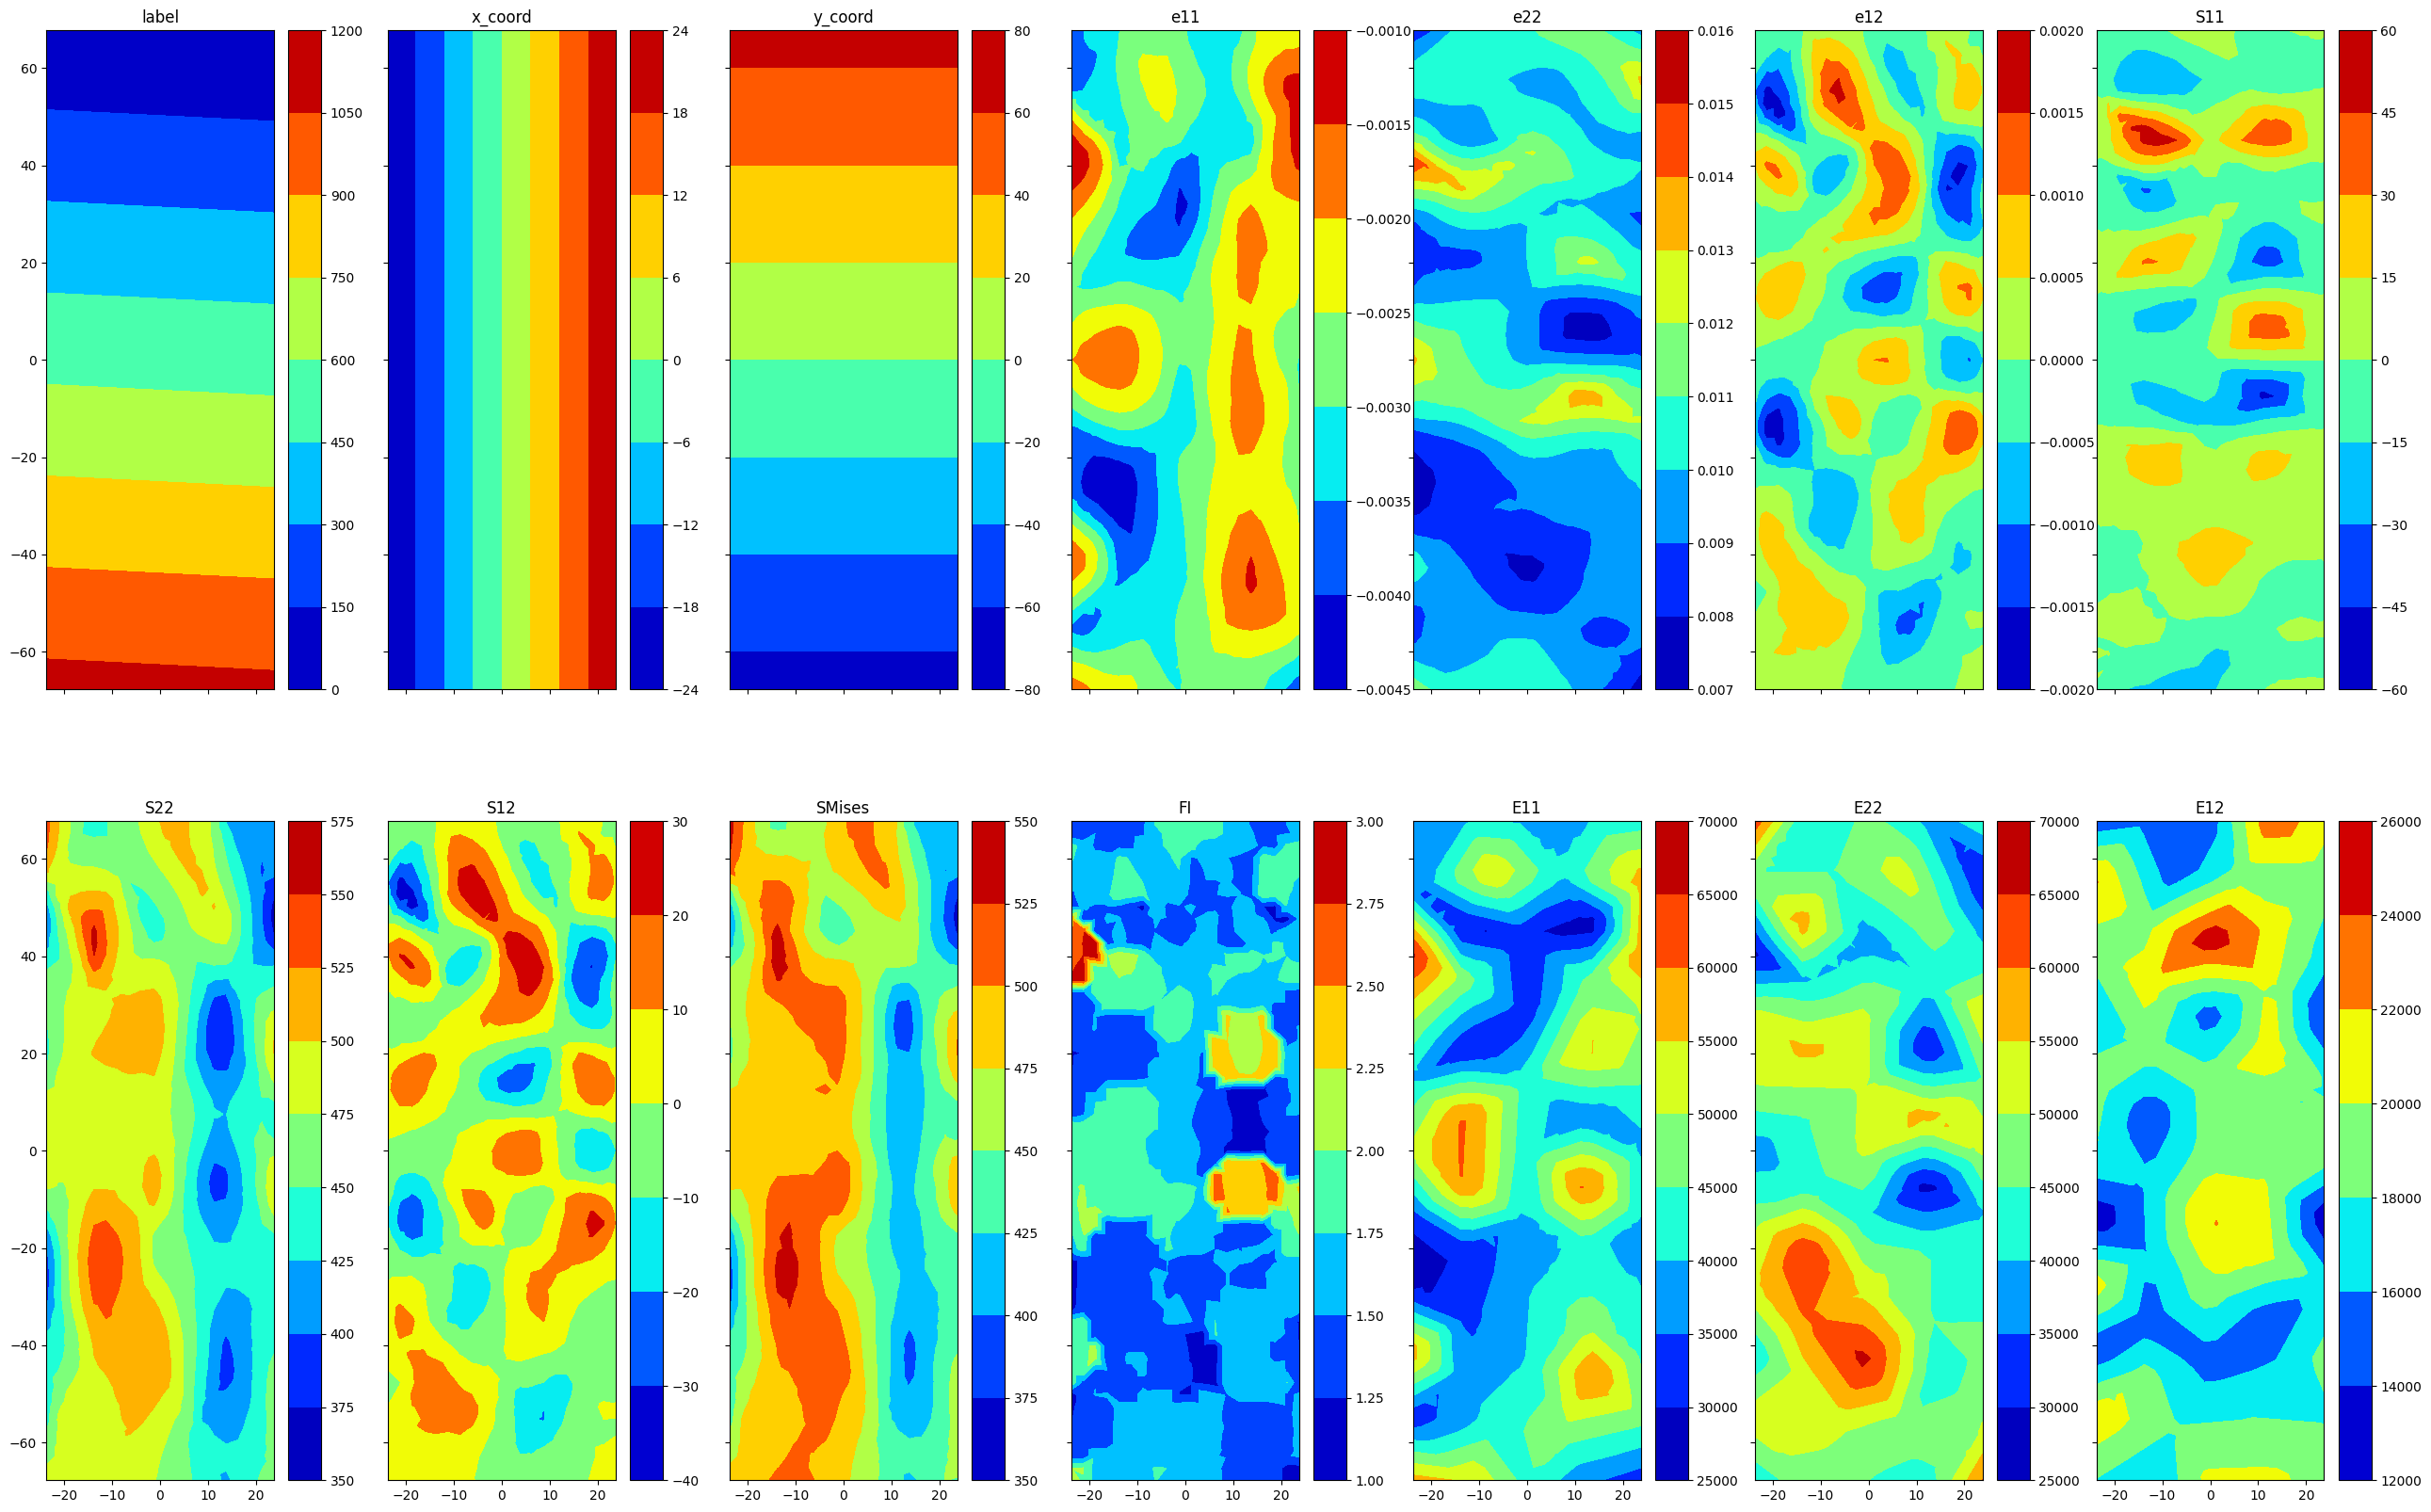

In [6]:
testHeaders, testSample = loadSample('data/Unnotched_TBDC_2022_0.csv')
print(testHeaders)
print(testSample)
import matplotlib.tri as tri
import matplotlib.ticker as plticker

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(testSample[:,1], testSample[:,2])
min_radius = 0.25
# Mask off unwanted triangles.
triang.set_mask(np.hypot(testSample[:,1][triang.triangles].mean(axis=1), testSample[:,2][triang.triangles].mean(axis=1)) < min_radius)

# Plot triangulation map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  tcf = ax.tricontourf(triang, testSample[:,i], cmap = 'jet')
  fig.colorbar(tcf)
  ax.set_title(testHeaders[i])


Alternative method without triangulation but reshaping into 2d matrix

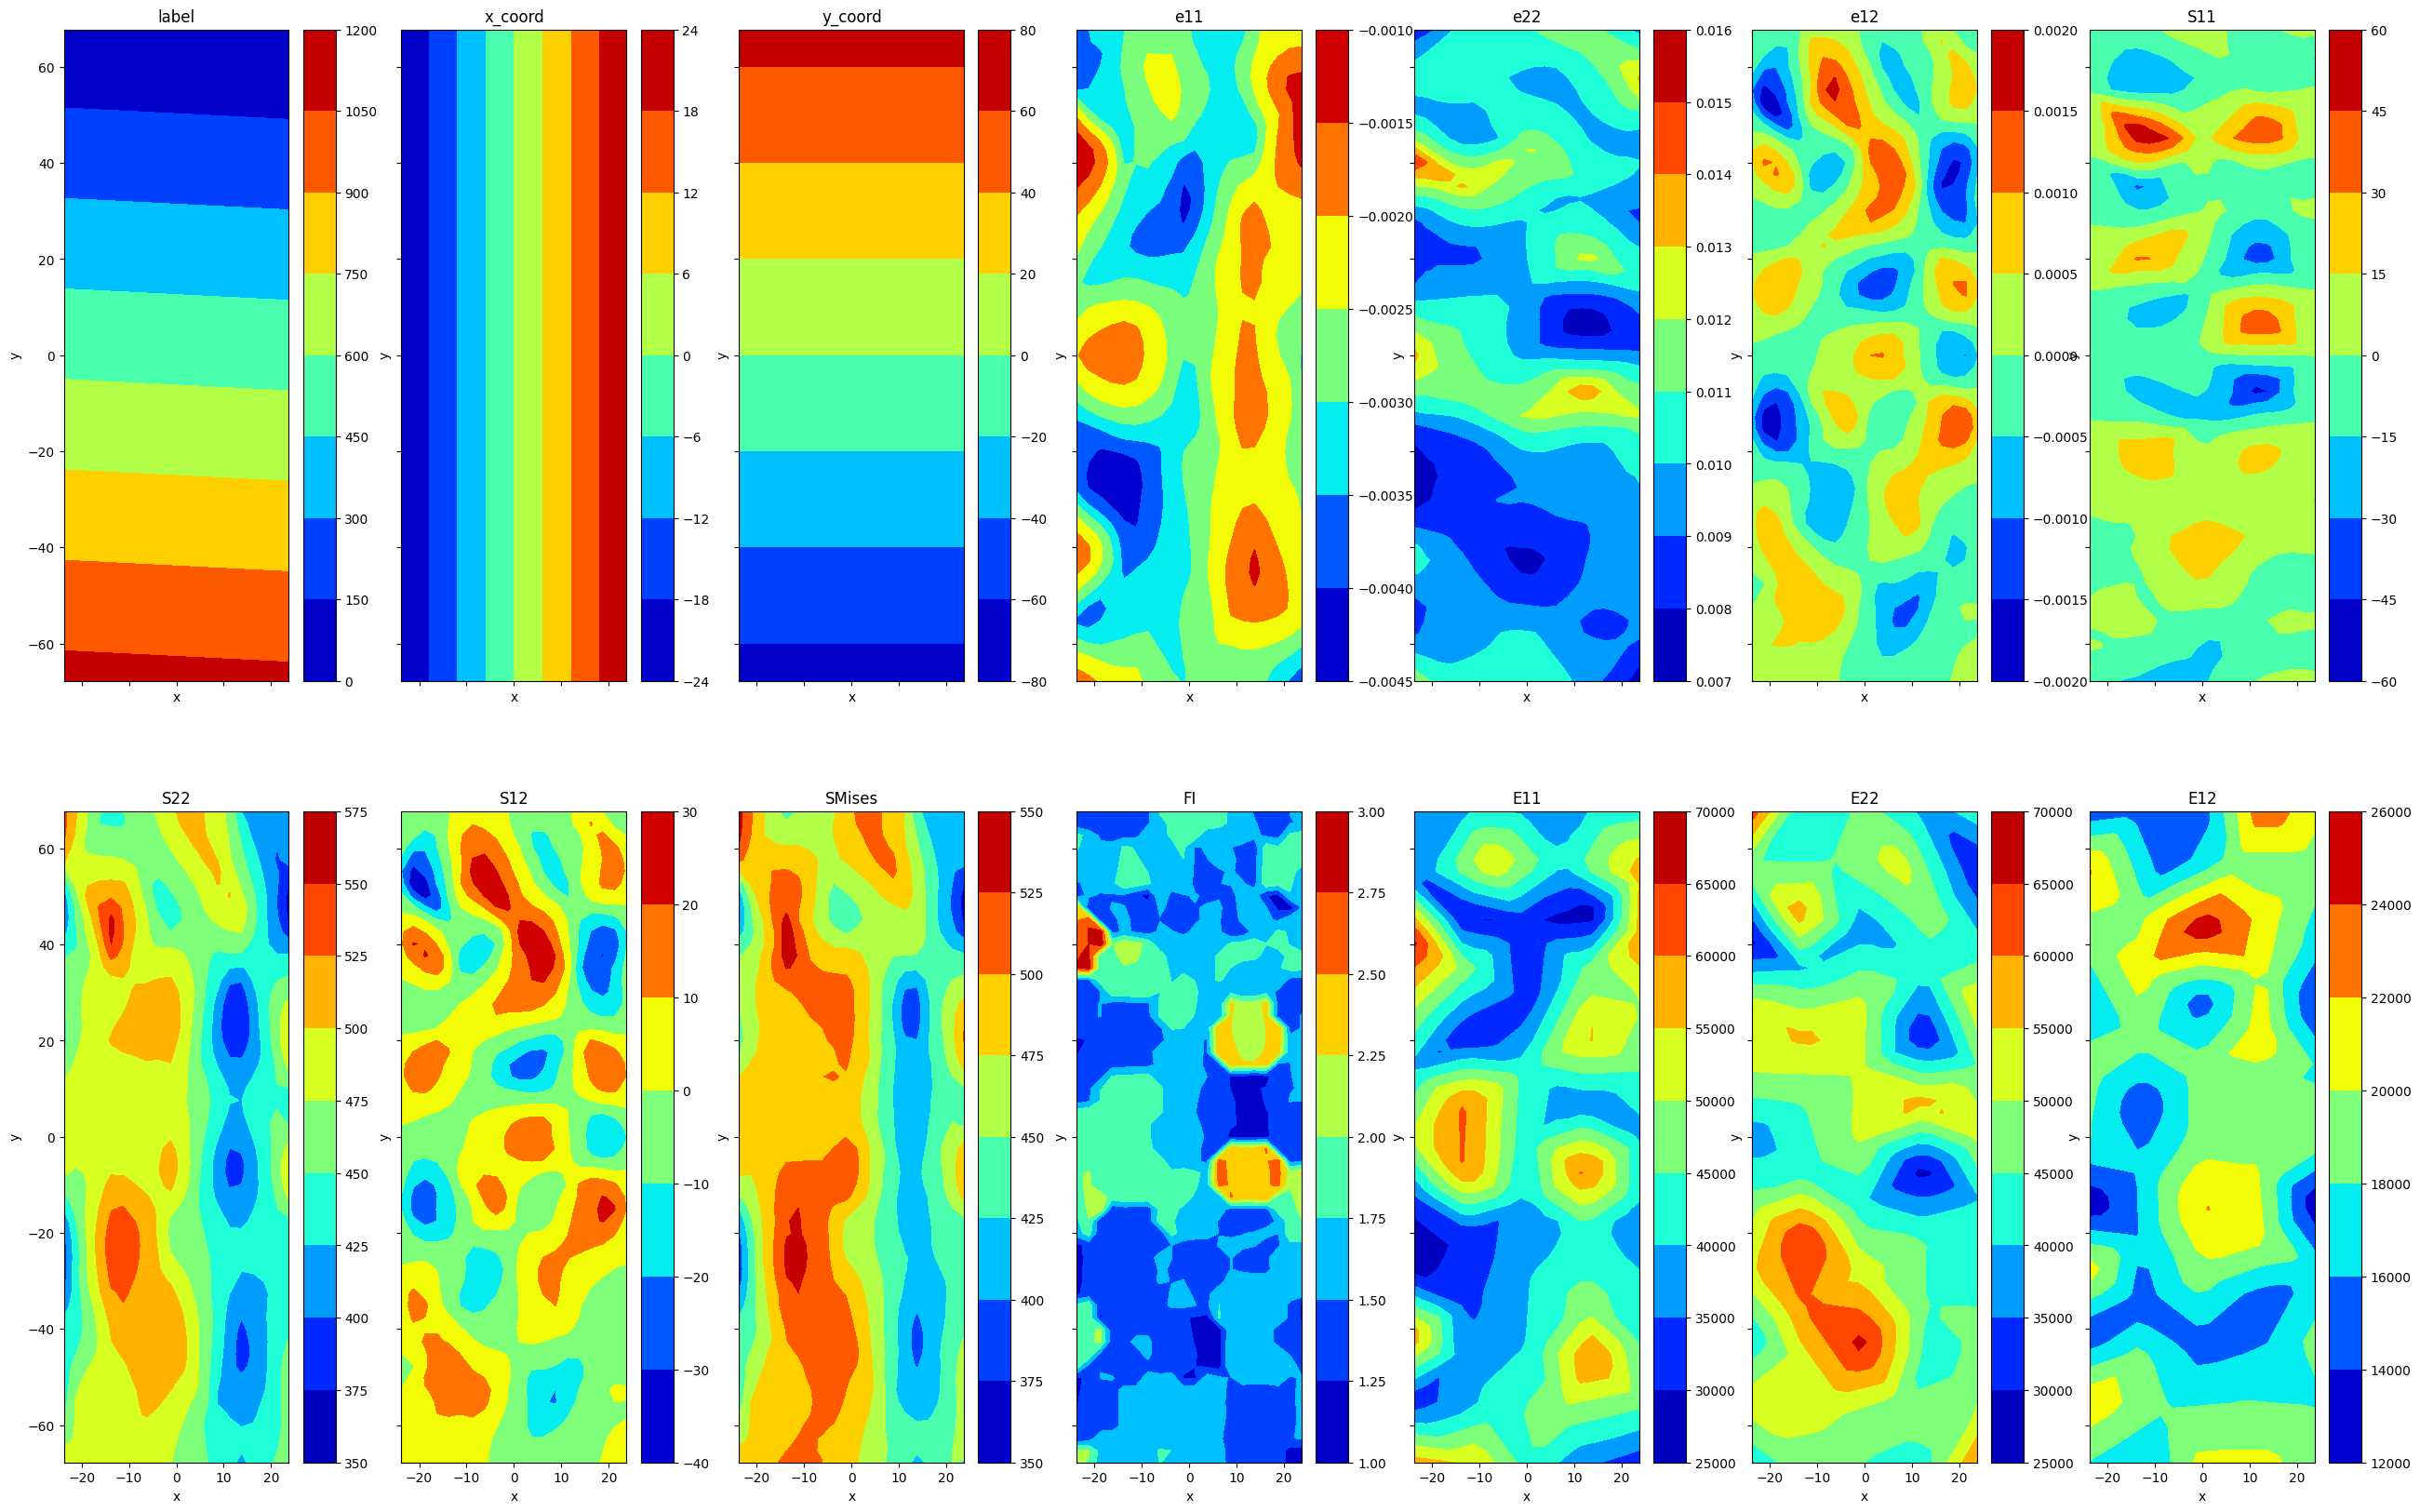

In [7]:
# Shape of specimen is 20x55
testReshaped = testSample.reshape(55,20,14)

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Plot  map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  CS = ax.contourf(testReshaped[:,:,1],testReshaped[:,:,2],testReshaped[:,:,i], cmap = 'jet')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(testHeaders[i])
  fig.colorbar(CS)

# Computing correlation stats

In [26]:
# Import all data samples
numSamples = 100

for i in range(numSamples):
  path = 'data/Unnotched_TBDC_2022_'+str(i)+'.csv'
  if i==0:
    headers, samples = loadSample(path)
    samples = samples.reshape(1, np.shape(samples)[0],np.shape(samples)[1])
  else:
    addSamp = loadSample(path)[1]
    samples = np.concatenate((samples,addSamp.reshape(1, np.shape(addSamp)[0],np.shape(addSamp)[1])))

# Reshape sample variable to have shape (samples, row, column, features)
samples2D = samples.reshape(np.shape(samples)[0],55,20,14)
print(np.shape(samples))
print(np.shape(samples2D))



(100, 1100, 14)
(100, 55, 20, 14)


In [ ]:
# # Test that import and reshape is correct
# fig, axs = plt.subplots(2, int(len(headers)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables
# sampleNum = 0
# # Plot  map
# for i in range(len(headers)):
#   ax = plt.subplot(2, int(len(headers)/2), i+1)
#   CS = ax.contourf(samples2D[sampleNum,:,:,1],samples2D[sampleNum,:,:,2],samples2D[sampleNum,:,:,i], cmap = 'jet')
#   plt.xlabel('x')
#   plt.ylabel('y')
#   plt.title(headers[i])
#   fig.colorbar(CS)

In [33]:
def normalise(input_matrix) -> tuple:
    '''
    Normalise values in matrix to lie between 0 and 1

    Args
    ----------
    input_matrix : np.array
        Numpy array of data in shape [55,20,14]
        OR
        Numpy array of data in shape [1100,14] if not reshaped
        There are 11 features which are each normalised, features 1, 2, and 3 are labels and x/y coordinates

    Returns
    ----------
    tuple
        Normalised array
    '''

    min_max_scaler = preprocessing.MinMaxScaler()
    for i in range(3, 14):
      if len(np.shape(input_matrix)) == 3:
        input_matrix[:,:,i] = preprocessing.minmax_scale(input_matrix[:,:,i], feature_range=(0, 1), axis=0, copy=True)
      elif len(np.shape(input_matrix)) == 2:
        input_matrix[:,i] = preprocessing.minmax_scale(input_matrix[:,i], feature_range=(0, 1), axis=0, copy=True)
      else:
        raise Exception("Data to be normalised not of correct shape")
    return input_matrix

Test normalisation function

In [17]:
# normalisedTest = normalise(testReshaped)

# fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# # Plot  map
# for i in range(len(testHeaders)):
#   ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
#   CS = ax.contourf(normalisedTest[:,:,1],normalisedTest[:,:,2],normalisedTest[:,:,i],levels = np.linspace(np.min(normalisedTest[:,:,i]),np.max(normalisedTest[:,:,i]),50), cmap = 'jet')
#   plt.xlabel('x')
#   plt.ylabel('y')
#   plt.title(testHeaders[i])
#   fig.colorbar(CS)

In [115]:
# Normalise data and calculate correlation coefficients to stiffness components

# Reminder: the header index is the following
# [   0        1         2       3     4     5     6     7     8      9      10   11    12    13  ]
# ['label' 'x_coord' 'y_coord' 'e11' 'e22' 'e12' 'S11' 'S22' 'S12' 'SMises' 'FI' 'E11' 'E22' 'E12']

featureIdxs = range(3,14)

# Pearson correlation coefficient describing linear correlation
pearsonCorrE11 = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with E11 (Horizontal stiffness)
pearsonCorrE11Pval = np.copy(pearsonCorrE11)
pearsonCorrE22 = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with E22 (vertical stiffness)
pearsonCorrE22Pval = np.copy(pearsonCorrE22)
pearsonCorrE12 = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with E12 (shear)
pearsonCorrE12Pval = np.copy(pearsonCorrE12)

# Spearman's correlation coefficient is the correlation of rank (i.e. if features monotonically increase together independent of proportionality)
spearmanCorrE11 = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with E11 (Horizontal stiffness)
spearmanCorrE11Pval = np.copy(spearmanCorrE11)
spearmanCorrE22 = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with E22 (vertical stiffness)
spearmanCorrE22Pval = np.copy(spearmanCorrE22)
spearmanCorrE12 = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with E12 (shear)
spearmanCorrE12Pval = np.copy(spearmanCorrE12)


for i in range(numSamples):
  samples[i] = normalise(samples[i]) # Normalise all features to [0,1] range
  for j, k in enumerate(featureIdxs): # Calculate correlation coefficients
    # E11
    pearsonCorrE11[i,j], pearsonCorrE11Pval[i,j] = scipy.stats.pearsonr(samples[i,:,11],samples[i,:,k])
    spearmanCorrE11[i,j], spearmanCorrE11Pval[i,j] = scipy.stats.spearmanr(samples[i,:,11],samples[i,:,k])

    # E22
    pearsonCorrE22[i,j], pearsonCorrE22Pval[i,j] = scipy.stats.pearsonr(samples[i,:,12],samples[i,:,k])
    spearmanCorrE22[i,j], spearmanCorrE22Pval[i,j] = scipy.stats.spearmanr(samples[i,:,12],samples[i,:,k])

    # E12
    pearsonCorrE12[i,j], pearsonCorrE12Pval[i,j] = scipy.stats.pearsonr(samples[i,:,13],samples[i,:,k])
    spearmanCorrE12[i,j], spearmanCorrE12Pval[i,j] = scipy.stats.spearmanr(samples[i,:,13],samples[i,:,k])



[Text(0, 0, 'e11'),
 Text(1, 0, 'e22'),
 Text(2, 0, 'e12'),
 Text(3, 0, 'S11'),
 Text(4, 0, 'S22'),
 Text(5, 0, 'S12'),
 Text(6, 0, 'SMises'),
 Text(7, 0, 'FI'),
 Text(8, 0, 'E11'),
 Text(9, 0, 'E22'),
 Text(10, 0, 'E12')]

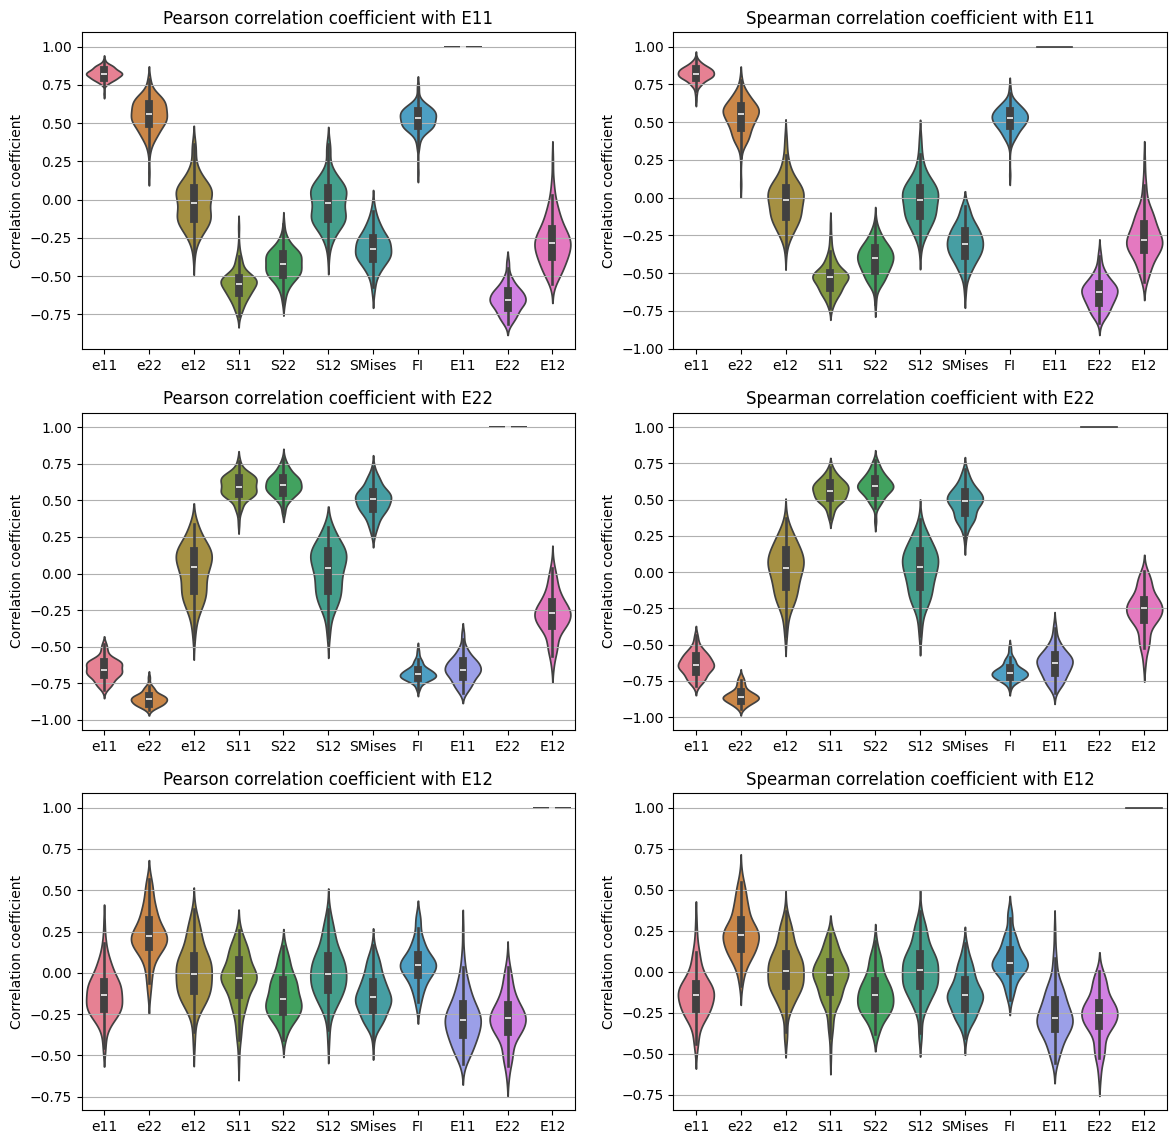

In [119]:
# Plot correlation coefficients
fig, axs = plt.subplots(3, 2, figsize=[14,14]) # Create subplots

# Plot correlation coefficients
axis = plt.subplot(3,2,1)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrE11)
plt.title('Pearson correlation coefficient with E11')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrE11[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(3,2,2)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrE11)
plt.title('Spearman correlation coefficient with E11')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrE11[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(3,2,3)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrE22)
plt.title('Pearson correlation coefficient with E22')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrE22[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(3,2,4)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrE22)
plt.title('Spearman correlation coefficient with E22')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrE22[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(3,2,5)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrE12)
plt.title('Pearson correlation coefficient with E12')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrE12[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(3,2,6)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrE12)
plt.title('Spearman correlation coefficient with E12')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrE12[0])))
g.set_xticklabels(headers[featureIdxs])


In [11]:
# explicit function to normalize array
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

E22 = testSample[:,12] # Stiffness
e22 = testSample[:,4] # Strain
FI = testSample[:,10]

E22norm = normalize_2d(E22)
e22norm = normalize_2d(e22)
FInorm = normalize_2d(FI)

In [12]:
sortIdx = np.rec.fromarrays([E22, e22, FI]) # Sort values based on ascending E22
sortIdx.sort()

E22sort = sortIdx.f0
e22sort = sortIdx.f1
FIsort = sortIdx.f2

cov = np.cov(E22norm,e22norm)
cov2 = np.cov(E22norm,FInorm)


In [13]:
# calculate Pearson's correlation
pCorr, _ = scipy.stats.pearsonr(E22, e22)
print('Pearsons correlation: %.3f' % pCorr)

# calculate Spearman's correlation
sCorr, _ = scipy.stats.spearmanr(E22, e22)
print('Spearmans correlation: %.3f' % sCorr)

Pearsons correlation: -0.927
Spearmans correlation: -0.929


Text(0, 0.5, 'e22')

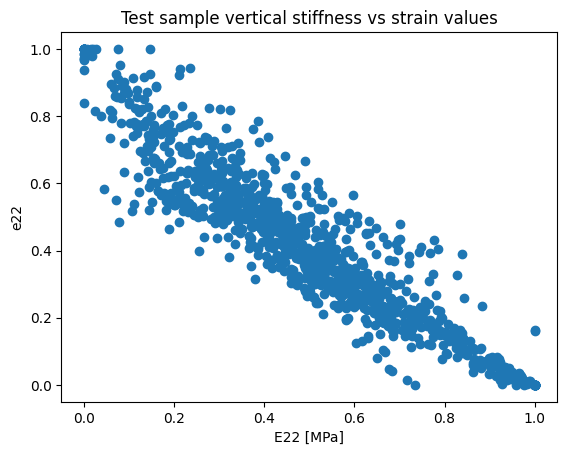

In [14]:
fig, axs = plt.subplots()
plt.scatter(E22,e22)
plt.title('Test sample vertical stiffness vs strain values')
plt.xlabel('E22 [MPa]')
plt.ylabel('e22')

Text(0, 0.5, 'FI')

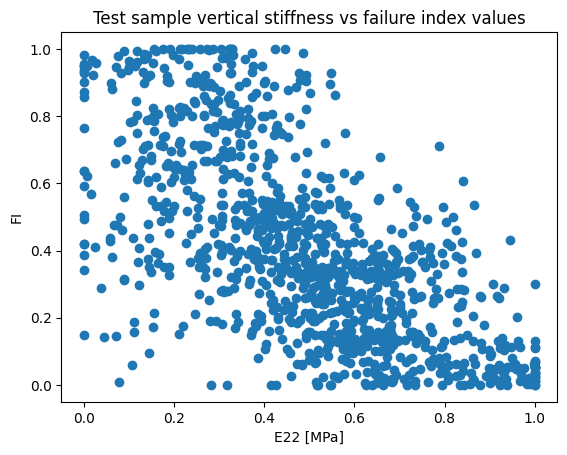

In [15]:
fig, axs = plt.subplots()
plt.scatter(E22,FI)
plt.title('Test sample vertical stiffness vs failure index values')
plt.xlabel('E22 [MPa]')
plt.ylabel('FI')